# ASTR 211 - HW03 - Sadie Seddon-Stettler

In [1]:
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plot_utils import plot_pretty
from codes.plot_utils import plot_histogram
from codes.plot_utils import plot_2d_dist
from codes.plot_utils import plot_line_points
from codes.plot_utils import plot_color_map
plot_pretty(fontsize=12)

from codes.histtools import shimazaki_shinomoto_rule
from codes.histtools import knuth_bin_width

from codes.read_data import read_jla_data

from codes.constants import clight

from codes.cosmology import d_L_romberg
from codes.cosmology import d_L_vectorized
from codes.cosmology import dl_func

from astropy.io import fits

from scipy import integrate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import RectBivariateSpline
from scipy.special import erf
from scipy.optimize import minimize

from progress.bar import Bar

In [2]:
hdulist = fits.open('data/sdss_galaxies.fits') 
data = np.asarray(hdulist[1].data)

In [3]:
print(data.dtype)

(numpy.record, [('objid', '>i8'), ('ra', '>f8'), ('dec', '>f8'), ('g', '>f4'), ('r', '>f4'), ('z', '>f4')])


## Task 1a

In [19]:
zmin, zmax = 0.01, 0.14
rmin, rmax = 12, 17.77
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

In [20]:
mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
gr = gr[(gr > 0) & (gr < 1.3)]

In [21]:
print(np.size(gr))
print(gr.min(), gr.max())

48099
0.00013923645 1.2980251


Histogram with integer bins:

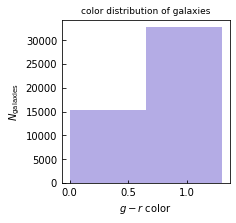

In [22]:
plot_histogram(gr, bins=2, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

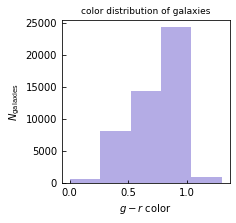

In [23]:
plot_histogram(gr, bins=5, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

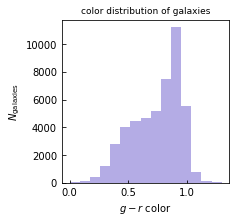

In [24]:
plot_histogram(gr, bins=15, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

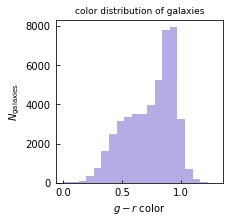

In [25]:
plot_histogram(gr, bins=20, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

Filtering to only values between 0 and 2 allows us to see the distribution much more clearly. Then, changing the number of bins allows us to see the shape of the distribution much more clearly - what is simply a lopsided peak at 2 or 5 bins turns into an interesting shape at 15 or 20 bins.

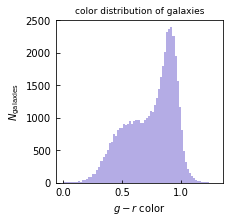

In [26]:
plot_histogram(gr, bins='auto', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

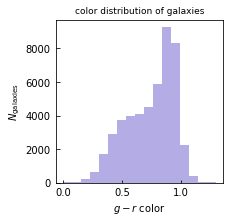

In [27]:
plot_histogram(gr, bins='sturges', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

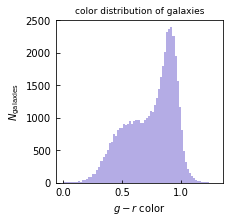

In [28]:
plot_histogram(gr, bins='fd', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

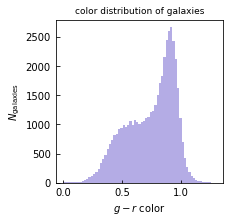

In [29]:
plot_histogram(gr, bins='scott', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

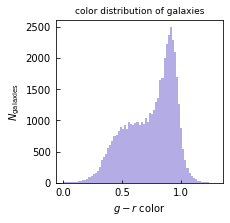

In [30]:
plot_histogram(gr, bins='rice', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

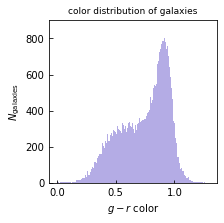

In [31]:
plot_histogram(gr, bins='sqrt', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

Again we see that the type of bins used changes the shape of the distribution, but this time much less drastically. All of the choices produce this similar two-peaked shape, but with different levels of noise. 'sturges' produces a very chunky plot, with few bins, whereas 'sqrt' produces a plot with many many small fluctuations visible. 'rice', 'scott', 'fd', and 'auto' all produce fairly similar looking distributions.

## Task 1b

In [32]:
zmin, zmax = 0.01, 0.14
rmin, rmax = 12, 17.77
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
mr = mr[(gr > 0) & (gr < 1.3)]
gr = gr[(gr > 0) & (gr < 1.3)]

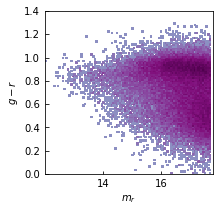

In [33]:
plot_2d_dist(mr, gr, xlim=[mr.min(), mr.max()], ylim=[0, 1.4],
             nxbins=100, nybins=100, 
             xlabel=r'$m_r$', ylabel=r'$g-r$', figsize=(3,3))

In [34]:
zmin, zmax = 0.01, 0.05
rmin, rmax = 15, 17
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
mr = mr[(gr > 0) & (gr < 1.3)]
gr = gr[(gr > 0) & (gr < 1.3)]

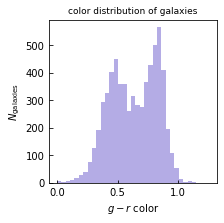

In [35]:
plot_histogram(gr, bins='scott', xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

For (0.01 < z < 0.05) and (15 < r < 17) we can see a new shape emerge, of a two-peaked distribution. (You can narrow r as well, but it makes the bins wider and thus harder to see the two peaks). Examining the 2D histogram mesh distribution gives us some insight as to why - when mr gets far enough to the right (nearer to 16 or 17), there is visible a 2-peak shape (the two areas of darker purple color). Then it's just a matter of tuning the z value to make that distribution visible, and narrowing it to 0.03 plus or minus 0.02 narrows it enough for us to see the two-peak shape.

## Task 1c

In [36]:
nss, hss = shimazaki_shinomoto_rule(gr, Nbmin=4, Nbmax=500)
print("number of bins according to Shimazaki-Shinomoto method is %d"%nss)

number of bins according to Shimazaki-Shinomoto method is 55


In [37]:
h_knuth, bins_knuth = knuth_bin_width(gr, return_bins=True)
n_knuth = np.shape(bins_knuth)[0] - 1
print("number of bins according to Knuth method is %d"%n_knuth)

Optimization terminated successfully.
         Current function value: -3407.894370
         Iterations: 16
         Function evaluations: 47
number of bins according to Knuth method is 37


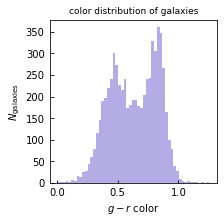

In [38]:
plot_histogram(gr, bins=nss, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

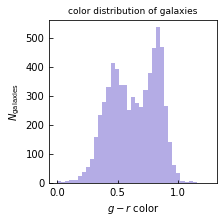

In [39]:
plot_histogram(gr, bins=n_knuth, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

For the same subsection of z and r values, using Knuth and Shimazaki-Shinomoto methods still show the two-peak distribution, looking almost identical to the scott binning method. Which is interesting, given that the number of bins calculated by Shimazaki-Shinomoto is 55 and Knuth is 37. This suggests to me that, at least for (0.01 < z < 0.05) and (15 < r < 17), the two-peak structure is actually real.

## Task 1d

For a 2d distribution, it is an unreasonable assumption that either of the axes will be a normal distribution - or at the least, the assumption of a normal distribution will throw us off greatly if we are wrong. We will also consider each axis as a separate distribution - it is safer to bin as if the two are not related, and apply the same binning method to both. I would like to avoid the slow growth of the Sturges and Rice rules, but I would like to adjust for some type of data spread. My heuristic method, which I am dubbing FDR, is a combination of the Freedman-Daconis and Square Root heuristic rules, and its calculated bin width scales with IQR and the square root of N:

$$h_{FDSR} = \frac{2IQR(x)}{\sqrt{N}}$$

In [40]:
def FDR_bins(x):
    max_min = x.max() - x.min()
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    bin_width = 2.0 * iqr * x.size ** (-1.0 / 2)
    return int(max_min // bin_width)

In [41]:
n_FDR = FDR_bins(gr)

Use those calculated bins to plot the 1d and 2d histograms! Let's first plot zoomed in on the two-peak part of the distribution:

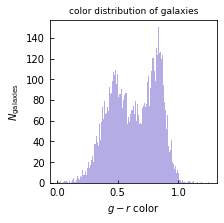

In [42]:
plot_histogram(gr, bins=n_FDR, xlabel=r'$g-r\ \rm color$', ylabel=r'$N_{\rm galaxies}$', 
               plot_title='color distribution of galaxies', figsize=3.0)

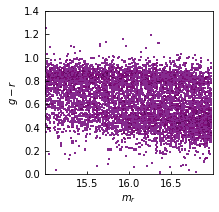

In [43]:
plot_2d_dist(mr, gr, xlim=[mr.min(), mr.max()], ylim=[0, 1.4],
             nxbins=n_FDR, nybins=n_FDR, 
             xlabel=r'$m_r$', ylabel=r'$g-r$', figsize=(3,3))

Or, we can take a look at how this binning method does overall:

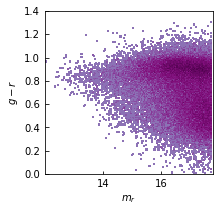

In [44]:
zmin, zmax = 0.01, 0.14
rmin, rmax = 12, 17.77
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

mr = data['r'][isel]
gr = data['g'][isel] - data['r'][isel]
mr = mr[(gr > 0) & (gr < 1.3)]
gr = gr[(gr > 0) & (gr < 1.3)]

plot_2d_dist(mr, gr, xlim=[mr.min(), mr.max()], ylim=[0, 1.4],
             nxbins=n_FDR, nybins=n_FDR, 
             xlabel=r'$m_r$', ylabel=r'$g-r$', figsize=(3,3))

Now, we plot the distribution of galaxies, first as points:

In [51]:
H0 = 70. 
d_C = clight * data['z'] / H0

ygal = d_C * np.cos(data['ra'] * np.pi / 180.)
xgal = d_C * np.sin(data['ra'] * np.pi / 180.)

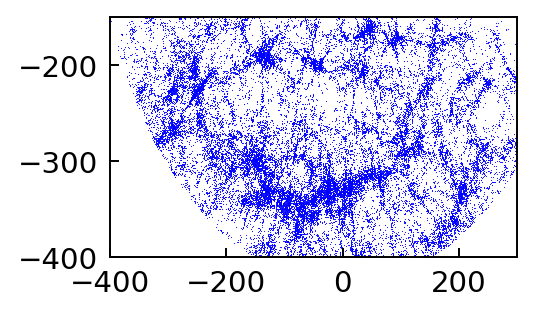

In [52]:
figx = 3.
xmin, xmax = -400.,  300.
ymin, ymax = -400., -150.

fxy = np.abs(ygal.max()-ygal.min()) / np.abs(xgal.max() - xgal.min())
figy = figx  * fxy

plot_pretty(fontsize=12)
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(figx,figy))
plt.xlim([xmin, xmax]); plt.ylim([ymin, ymax])

ax.scatter(xgal, ygal, s=0.2, lw=0, c='b')

plt.show()

And now, as a 2D histogram for comparison:

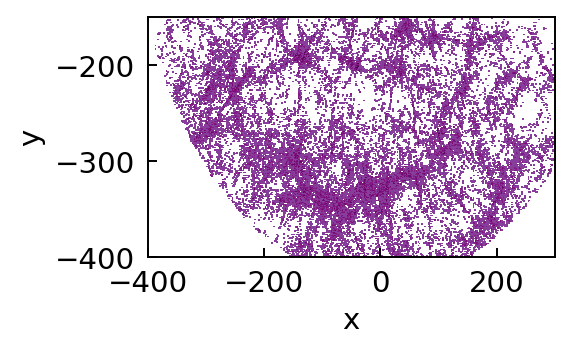

In [57]:
nx_FDR = FDR_bins(xgal)
ny_FDR = FDR_bins(ygal)

plot_2d_dist(xgal, ygal, xlim=[xmin, xmax], ylim=[ymin, ymax],
             nxbins=nx_FDR, nybins=ny_FDR, figsize=(figx,figy))

Since the 2D histogram, broadly speaking, resembles the plot-as-points plot, I would say that the bin number produced by my heuristic is reasonable in this case as well. It keeps the structure without getting so granular as to basically be a plot-as-points method.

## Task 2a

In [4]:
zCMB, mB, emB = read_jla_data(sn_list_name = 'data/jla_lcparams.txt')
print("read sample of %d supernovae..."%(np.size(zCMB)))
H0 = 70

read sample of 740 supernovae...


For simplicity's sake, copy in our code from exercise 2 of HW2 to use here:

In [5]:
def chebyshev_nodes1(a, b, N):
    nodes = a + 0.5*(b-a)*(1. + np.cos((2.*np.arange(N+0)+1)*np.pi/(2.*(N+0))))
    nodes = nodes[::-1]
    return nodes

In [6]:
ntrain = 10

Om0min, Om0max = 0., 1
OmLmin, OmLmax = 0., 1
Om0tr = chebyshev_nodes1(Om0min, Om0max, ntrain)
OmLtr = chebyshev_nodes1(OmLmin, OmLmax, ntrain)
d_L_train = np.zeros((ntrain, ntrain))

def tilde_d_L(Om0, OmL, z):
    for i, Omd in enumerate(Om0):
        for j, Omld in enumerate(OmL):
                d_L_train[i][j] = H0 / clight * d_L_vectorized(z, H0, Omd, Omld, atol=5.e-16, rtol=5.e-16)

    spl2d = RectBivariateSpline(Om0, OmL, d_L_train, s=0, kx=3, ky=3)
    
    return spl2d

In [7]:
nOm0, nOmL = np.size(Om0tr), np.size(OmLtr)
ntrx, ntry = nOm0, nOmL

dLz = []

for iz, zi in enumerate(zCMB):
    d_l_spl = tilde_d_L(Om0tr, OmLtr, zi)
    dLz.append(d_l_spl)

In [8]:
def chi2(parameters):
    Omega0, OmegaL, tM0 = parameters
    chi2_z = np.empty(np.size(zCMB))
    for iz, zi in enumerate(zCMB):
        spline = dLz[iz]
        d_L = spline(Omega0, OmegaL)[0][0]
        chi2_z[iz] = ((mB[iz] - 5*np.log10(d_L) - tM0) ** 2) / (emB[iz] ** 2)
    chi2 = np.sum(chi2_z)
    return chi2

def reduced_chi2(parameters):
    return chi2(parameters) / (740-3)

In [9]:
print(chi2([0.9, 0.9, -19.1]))
print(reduced_chi2([0.9, 0.9, -19.1]))

111034533.58381256
150657.44041222872


## Task 2b

In [10]:
def find_tM0(M0):
    return M0 + 5*np.log10(clight/H0) + 25

In [11]:
nParameters = 100
Omega0s = np.linspace(Om0min, Om0max, nParameters)
OmegaLs = np.linspace(OmLmin, OmLmax, nParameters)
M0s = np.linspace(-18.6, -19.6, nParameters)
tM0s = find_tM0(M0s)

In [12]:
chi2_2b = np.empty([nParameters,nParameters,nParameters])
i = 1
for Omega0_i, Omega0 in enumerate(Omega0s):
    for OmegaL_i, OmegaL in enumerate(OmegaLs):
        for tM0_i, tM0 in enumerate(tM0s):
            chi2_2b[Omega0_i, OmegaL_i, tM0_i] = reduced_chi2([Omega0, OmegaL, tM0])
            print("{0} of 1,000,000 ({1}%) Processed".format(i, i/10000), end="\r")
            i += 1

In [13]:
inds = np.unravel_index(np.argmin(chi2_2b, axis=None), chi2_2b.shape)
rv = 'The minimum value of the array located at: {}\n\tOmega0 = {}\n\tOmegaL = {}\n\ttM0 = {}\n\tchi^2 = {}'
rv = rv.format(inds, Omega0s[inds[0]], OmegaLs[inds[1]], tM0s[inds[2]], chi2_2b[inds])
print(rv)

The minimum value of the array located at: (39, 36, 45)
	Omega0 = 0.393939393939394
	OmegaL = 0.36363636363636365
	tM0 = 24.104067860022898
	chi^2 = 6.212663798744104


## Task 2c

In [14]:
Omega0_guess = .5 * (Om0min + Om0max)
Omega0_bounds = (Om0min, Om0max)
OmegaL_guess = .5 * (OmLmin + OmLmax)
OmegaL_bounds = (OmLmin, OmLmax)
tM0_guess = .5 * (tM0s[0] + tM0s[-1])
guesses = [Omega0_guess, OmegaL_guess, tM0_guess]
bounds = [Omega0_bounds, OmegaL_bounds, (tM0s[0], tM0s[-1])]
res = minimize(reduced_chi2, guesses, method='Nelder-Mead', bounds=bounds, options={ 'disp': True}) #Packed the chi2 function to do this
print("minimum at :",res.x)
print('chi^2 :', reduced_chi2(res.x))

C:\Users\sadie\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: 6.212471
         Iterations: 123
         Function evaluations: 219
minimum at : [ 0.37476108  0.32217048 24.10833977]
chi^2 : 6.212470770567718


Since the reduced $chi^2$ of our best model is around 6, we can say that the model is definitely not overfitting, and that it is also not a completely correct model. Considering that we are on the order of $10^1$, but that our value is 6, not close to 1-2, we estimate that the model is broadly speaking decent but probably missing a few parameters. 

## Task 2d

In [16]:
min_chi2_fn = (740-3)*chi2_2b[:, :, 45]
xg, yg = np.meshgrid(Omega0s, OmegaLs)
levs = [min_chi2_fn.min()+3.53, min_chi2_fn.min()+8.03]

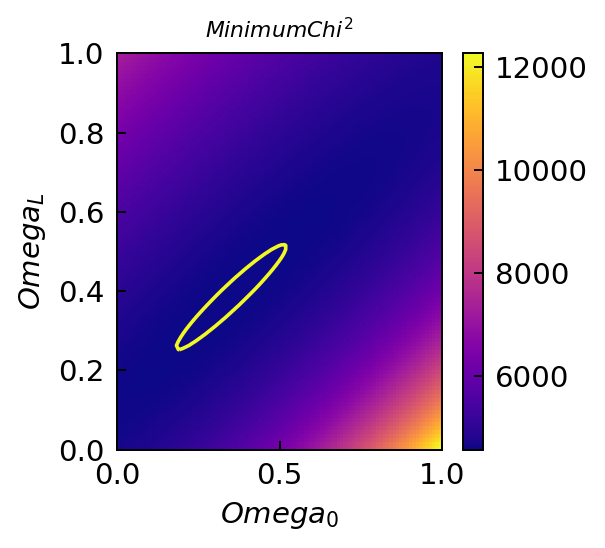

In [60]:
plot_color_map(xg, yg, min_chi2_fn, xlim=[Om0min,Om0max], ylim=[OmLmin,OmLmax], 
                   xlabel = r'$Omega_0$', ylabel = '$Omega_L$', cmap='plasma', colorbar=True, 
                   plot_title=r'$Minimum Chi^2$', contours=True, 
                   contcmap='plasma', levels = levs, 
                   figsize=3.0)

From the plot, our results fall within the range that we were expecting - we have a minimum zone that covers around Omega0 = OmegaL = 0.5. More generally speaking, our plot also shows that values of $chi^2$ are lowest along a diagonal in the middle, i.e. where Omega0 and OmegaL are at least close to equal. From our plot, we say that the constraints that the supernovae measurements give us for Omega0 and OmegaL parameters are:

(0.2 < Omega0 < O.6)
and
(0.25 < OmegaL < 0.55)